<a href="https://colab.research.google.com/github/FarahBouattour/knowWhatToEat/blob/main/Multioutput_time_series.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
print(tf.__version__)

2.5.0


In [129]:
from sklearn.preprocessing import MinMaxScaler

d21 = pd.read_csv('test_data_pca_dt_covid_fi.csv')
d20 = pd.read_csv('data_pca_dt_covid_fi.csv')
# 2019 - 2020
d20 = d20.iloc[1461:,:]
d21_train = d21.iloc[:100,:]
d21_test = d21.iloc[100:,:]
df = pd.concat([d20,d21_train], ignore_index=True)

#Separate dates for future plotting
train_dates = pd.to_datetime(df['Date'])

#Variables for training 
cols = list(df)[2:5]
df_for_training = df[cols].astype(float)

training_data = df_for_training.to_numpy()


trainX = []
trainY = []

n_future = 1   # Number of days we want to predict into the future
window_size = 14    # Number of past days we want to use to predict the future

for i in range(window_size, len(df_for_training) - n_future +1):
    trainX.append(training_data[i - window_size:i, :df_for_training.shape[1]])
    trainY.append(training_data[i + n_future - 1:i + n_future, :4])


trainX, trainY = np.array(trainX), np.array(trainY)
trainY = np.squeeze(trainY)
print('trainX shape == {}.'.format(trainX.shape))
print('trainY shape == {}.'.format(trainY.shape))


trainX shape == (817, 14, 3).
trainY shape == (817, 3).


In [130]:
model = tf.keras.models.Sequential([
  tf.keras.layers.Conv1D(filters=16, kernel_size=5, strides=1, 
                         padding="causal", 
                         activation="relu", 
                         input_shape=(trainX.shape[1], trainX.shape[2])),
  tf.keras.layers.LSTM(16, return_sequences=True),
  tf.keras.layers.SimpleRNN(16, return_sequences=False),
  tf.keras.layers.Dense(60, activation="relu"),
  tf.keras.layers.Dropout(0.2),
  tf.keras.layers.Dense(30, activation="relu"),
  tf.keras.layers.Dense(trainY.shape[1]),
  tf.keras.layers.Lambda(lambda x: x * 100)
])


lr_schedule = tf.keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-8 * 10**(epoch / 20))
optimizer = tf.keras.optimizers.SGD(learning_rate=1e-4, momentum=0.9)
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae", "mape"])

history = model.fit(trainX, trainY, epochs=55, batch_size=32,
                    validation_split=0.4, verbose=1,
                    callbacks=[lr_schedule])

Epoch 1/55
16/16 [==============================] - 3s 55ms/step - loss: 69.5554 - mae: 70.0544 - mape: 84.1345 - val_loss: 43.5974 - val_mae: 44.0961 - val_mape: 66.8924
Epoch 2/55
16/16 [==============================] - 0s 21ms/step - loss: 69.5753 - mae: 70.0749 - mape: 80.1696 - val_loss: 43.5526 - val_mae: 44.0514 - val_mape: 66.8619
Epoch 3/55
16/16 [==============================] - 0s 21ms/step - loss: 70.2300 - mae: 70.7294 - mape: 84.0169 - val_loss: 43.5054 - val_mae: 44.0047 - val_mape: 66.8305
Epoch 4/55
16/16 [==============================] - 0s 21ms/step - loss: 69.1041 - mae: 69.6037 - mape: 82.2310 - val_loss: 43.4357 - val_mae: 43.9354 - val_mape: 66.7835
Epoch 5/55
16/16 [==============================] - 0s 22ms/step - loss: 69.0341 - mae: 69.5340 - mape: 78.8174 - val_loss: 43.3102 - val_mae: 43.8095 - val_mape: 66.6558
Epoch 6/55
16/16 [==============================] - 0s 21ms/step - loss: 69.4236 - mae: 69.9235 - mape: 80.7903 - val_loss: 43.0782 - val_mae: 43

(1e-07, 0.002, 10.0, 100.0)

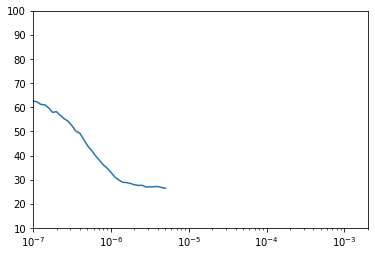

In [131]:
plt.semilogx(history.history["lr"], history.history["loss"])
plt.axis([1e-7, 2e-3, 10, 100])

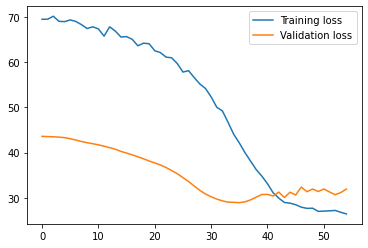

In [132]:
plt.plot(history.history['loss'], label='Training loss')
plt.plot(history.history['val_loss'], label='Validation loss')
plt.legend()

In [133]:
forecast_period = d21_test.shape[0]  
forecast_period_dates = pd.date_range(list(train_dates)[-1], periods=forecast_period, freq='1d').tolist()

forecast = model.predict(trainX[-n_future:]) #(1,31,10) shape of trainX[-n_future]
forecast

array([[41.212048, 30.570988, 44.493332]], dtype=float32)

In [134]:
result = np.zeros((31, 3))
#result[0] = scaler.inverse_transform(forecast)[:,:4][0]
result[0] = [abs(int(i)) for i in forecast[:,:4][0]]
trainX[-1][-1][:3] = trainY[-1]

for i in range(30):
  y_pred_row = forecast
  row = list(y_pred_row[0])
  test = np.zeros((1, window_size, 3))
  test[0][:window_size - 1] = trainX[-1:][0][1:]
  test[0][window_size - 1] = row
  trainX = test
  forecast = model.predict(trainX)
  #print(forecast)
  #result[i] = scaler.inverse_transform(forecast)[:,:4][0]
  result[i+1] = [abs(int(i)) for i in forecast[:,:4][0]]

result

array([[41., 30., 44.],
       [41., 36., 56.],
       [42., 34., 52.],
       [33., 30., 52.],
       [50., 50., 56.],
       [59., 60., 55.],
       [37., 53., 70.],
       [39., 40., 52.],
       [40., 71., 83.],
       [34., 40., 49.],
       [26., 33., 57.],
       [35., 38., 51.],
       [28., 32., 54.],
       [33., 29., 45.],
       [39., 38., 56.],
       [33., 33., 46.],
       [35., 34., 47.],
       [35., 34., 50.],
       [34., 30., 50.],
       [41., 35., 57.],
       [24., 31., 42.],
       [38., 39., 53.],
       [31., 29., 50.],
       [41., 36., 53.],
       [38., 35., 46.],
       [41., 35., 52.],
       [39., 37., 44.],
       [40., 30., 54.],
       [37., 49., 31.],
       [47., 43., 48.],
       [40., 53., 33.]])

In [135]:
# Convert timestamp to date
forecast_dates = []
for time_i in forecast_period_dates:
    forecast_dates.append(time_i.date())
    
df_forecast = pd.DataFrame({'Date':np.array(forecast_dates[:31]), 
                            'chirurgie':result[:,0],
                            'medicale':result[:,1],
                            'orthopedie':result[:,2]})
                            #'flux_journalier':result.sum(axis=1)})
df_forecast['Date']=pd.to_datetime(df_forecast['Date'])

cols = list(df)[:5]
original = df[cols]
original['Date']=pd.to_datetime(original['Date'])
original = original.loc[original['Date'] >= '2021-03-1']

#the real data that we predict
real = d21_test
real = real.iloc[:31,2:5].reset_index()

real.reset_index()
results = pd.concat([df_forecast, real], axis=1)
results

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  from ipykernel import kernelapp as app


,Date,chirurgie,medicale,orthopedie,index,CHIRURGIE,MEDICALE,ORTHOPEDIE
0,2021-04-10,41.0,30.0,44.0,100,27.0,39.0,87.0
1,2021-04-11,41.0,36.0,56.0,101,67.0,108.0,70.0
2,2021-04-12,42.0,34.0,52.0,102,51.0,69.0,61.0
3,2021-04-13,33.0,30.0,52.0,103,43.0,76.0,78.0
4,2021-04-14,50.0,50.0,56.0,104,40.0,87.0,77.0
5,2021-04-15,59.0,60.0,55.0,105,36.0,77.0,69.0
6,2021-04-16,37.0,53.0,70.0,106,42.0,92.0,43.0
7,2021-04-17,39.0,40.0,52.0,107,17.0,53.0,41.0
8,2021-04-18,40.0,71.0,83.0,108,46.0,88.0,60.0
9,2021-04-19,34.0,40.0,49.0,109,41.0,77.0,71.0


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


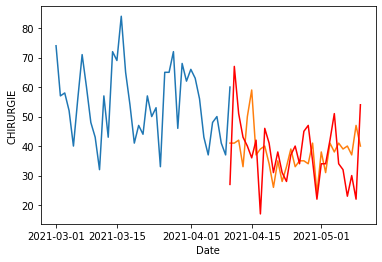

In [136]:
sns.lineplot(original['Date'], original['CHIRURGIE'])
sns.lineplot(df_forecast['Date'], df_forecast['chirurgie'])
sns.lineplot(df_forecast['Date'], real['CHIRURGIE'], color='r')

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


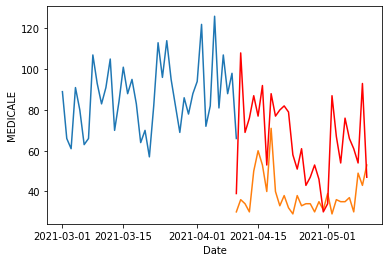

In [137]:
sns.lineplot(original['Date'], original['MEDICALE'])
sns.lineplot(df_forecast['Date'], df_forecast['medicale'])
sns.lineplot(df_forecast['Date'], real['MEDICALE'], color='r')

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


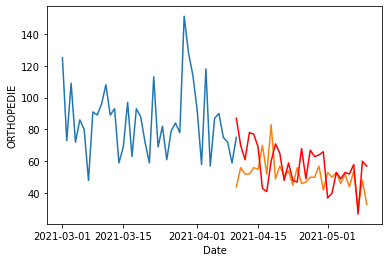

In [138]:
sns.lineplot(original['Date'], original['ORTHOPEDIE'])
sns.lineplot(df_forecast['Date'], df_forecast['orthopedie'])
sns.lineplot(df_forecast['Date'], real['ORTHOPEDIE'], color='r')